# Polkadot Price Prediction Using **sklearn**

In this project I'll be working with csv taken from [subscan](https://polkadot.subscan.io/tools/charts). I use 8 files, listed below with a brief description:

**Daily Active Account & Newly Created Account.csv**:  the daily active accounts and new accounts created.

**Daily Bond Value (DOT).csv**: daily amount (in dot) bonded for staking.

**Daily Fees Used.csv**: daily amount of fees (in dot) spent on the network.

**Daily Transaction Amount.csv**: amount transacted on the network.

**Daily Unbonding Schedule (DOT).csv**: dot scheduled to be released from staking.

**DOT Price (USD).csv**: the price in USD of 1 dot.

**Treasury Available Income.csv**: available income of treasury (in dot).

**Treasury Expenses.csv**: expenses per day of treasury.


## import packages and csv files

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

In [2]:
active_inactive = pd.read_csv("data/Daily Active Account & Newly Created Account.csv", parse_dates=['Date'])
bond = pd.read_csv("data/Daily Bond Value (DOT).csv", parse_dates=['Date'])
fees = pd.read_csv("data/Daily Fees Used.csv", parse_dates=['Date'])
transactions = pd.read_csv("data/Daily Transaction Amount.csv", parse_dates=['Date'])
unbonding = pd.read_csv("data/Daily Unbonding Schedule (DOT).csv", parse_dates=['Date'])
price = pd.read_csv("data/DOT Price (USD).csv", parse_dates=['Date'])
treasury_available = pd.read_csv('data/Treasury Available Income.csv', parse_dates=['Date'])
treasury_expense = pd.read_csv('data/Treasury Expenses.csv', parse_dates=['Date'])

## rename columns

In [3]:
active_inactive = active_inactive.rename(columns={'Active Account': 'Active_account', 'New Account': 'New_account'})
bond = bond.rename(columns={'Value':'Bond_value'})
fees = fees.rename(columns={'DOT':'DOT_fees'})
transactions = transactions.rename(columns={'DOT':'DOT_transactions'})
unbonding = unbonding.rename(columns={'Value':'Unbonding_value'})
price = price.rename(columns={' Price (USD)': 'Price_USD'})
treasury_available = treasury_available.rename(columns={'Value': 'available_value'})
treasury_expense = treasury_expense.rename(columns={'Value': 'expense_value'})

## merge DataFrames, clean, create target

In [4]:
df = [price, transactions, fees, bond, unbonding, active_inactive, treasury_available, treasury_expense]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['Date'], how='outer'), df)

In [5]:
df_merged['Seven_day_price'] = df_merged['Price_USD'].shift(-7)
df_merged = df_merged.dropna()

In [6]:
display(df_merged.head())
display(df_merged.tail())

,Date,Price_USD,DOT_transactions,DOT_fees,Bond_value,Unbonding_value,Active_account,New_account,available_value,expense_value,Seven_day_price
1,2020-07-18,1.750289,600.0,4.2493,3.225823e+05,49257.838569,197.0,30.0,0.0,0.0,1.709566
2,2020-07-19,1.605382,666.0,9.9014,2.009450e+07,274420.000000,395.0,21.0,0.0,0.0,1.678297
3,2020-07-20,1.571536,7000.0,5.8391,2.922391e+07,18027.400000,286.0,30.0,0.0,0.0,1.702217
4,2020-07-21,1.588110,0.0,4.5909,1.489727e+05,25100.000000,173.0,18.0,0.0,0.0,1.770439
5,2020-07-22,1.570872,0.0,3.7842,2.527056e+06,800000.000000,169.0,11.0,0.0,0.0,1.771341


,Date,Price_USD,DOT_transactions,DOT_fees,Bond_value,Unbonding_value,Active_account,New_account,available_value,expense_value,Seven_day_price
634,2022-04-12,17.941162,8.573963e+06,165.978411,1.241070e+07,2.034294e+04,1917.0,2108.0,2.804684e+07,0.0,18.999490
635,2022-04-13,18.063836,1.941962e+07,147.440837,1.049751e+05,1.325278e+05,1757.0,1839.0,2.812011e+07,0.0,19.100654
636,2022-04-14,18.164701,4.887517e+06,174.040428,8.649407e+05,3.778230e+06,3006.0,2066.0,2.819367e+07,0.0,18.329985
637,2022-04-15,18.428432,1.104774e+07,138.297388,5.594405e+04,4.663664e+04,1570.0,1725.0,2.826710e+07,0.0,18.660793
638,2022-04-16,18.494261,1.978290e+06,138.533526,5.663654e+04,3.605870e+05,1524.0,1872.0,2.833720e+07,0.0,18.954922


## visual exploration

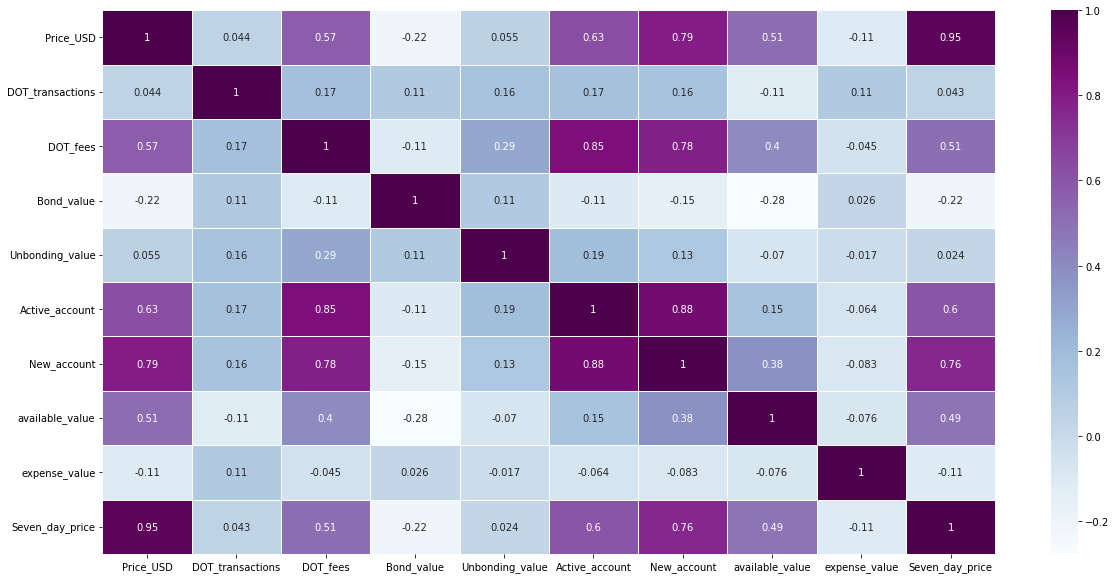

In [7]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_merged.corr(), annot=True, cmap='BuPu', linewidth=1, linecolor='w');

> We can see here a (unsurprising) high correlation between the Price_USD and Seven_day_price. New_account, Active_account, DOT_fees, and available_value also have a high correlation with Seven_day_price, but we must determine whether they are correlated with each other before they can be used in the model. 

### investigate correlations between features

In [8]:
corr = df_merged.corr()

In [9]:
corr_df = corr.unstack().reset_index()
corr_df.columns = ['feature_1','feature_2', 'correlation']
corr_df.sort_values(by="correlation",ascending=False, inplace=True)
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']]
feature_correlation = corr_df[corr_df['feature_1'] == 'Seven_day_price']

In [10]:
corr_df.head()

,feature_1,feature_2,correlation
90,Seven_day_price,Price_USD,0.950528
9,Price_USD,Seven_day_price,0.950528
65,New_account,Active_account,0.876939
56,Active_account,New_account,0.876939
25,DOT_fees,Active_account,0.845768


In [11]:
feature_correlation.head()

,feature_1,feature_2,correlation
90,Seven_day_price,Price_USD,0.950528
96,Seven_day_price,New_account,0.758976
95,Seven_day_price,Active_account,0.604790
92,Seven_day_price,DOT_fees,0.506402
97,Seven_day_price,available_value,0.488297


## use permutation_importance to find most important features

### create feature matrix (X) and target vector (y)

In [12]:
X_permutation = df_merged.copy().drop(['Seven_day_price', 'Date'], axis=1)
y_permutation = df_merged['Seven_day_price']

### run feature permutation

In [13]:
regressor = LinearRegression().fit(X_permutation, y_permutation)
permutation_score = permutation_importance(regressor, X_permutation, y_permutation, n_repeats=10)
importance_df = pd.DataFrame(np.vstack((X_permutation.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

importance_df = importance_df.sort_values(by="score decrease", ascending = False)

In [14]:
importance_df

,feature,score decrease
0,Price_USD,1.635726
2,DOT_fees,0.082483
5,Active_account,0.066268
7,available_value,0.009096
1,DOT_transactions,0.00045
6,New_account,0.000333
3,Bond_value,0.000092
4,Unbonding_value,0.000008
8,expense_value,-0.000042


> importance_df shows that only four features have a noticeable effect on the score of the model

In [15]:
importance_df = importance_df[importance_df['score decrease'] > 0.008]

### redefine X with only four features, and define y

In [16]:
X = df_merged.loc[:, importance_df['feature']]
X['Date'] = df_merged.Date
y = df_merged[['Date', 'Seven_day_price']]

### split the data into train and test

In [17]:
min_date = X.Date.min()
max_date = X.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2020-07-18 00:00:00 Max: 2022-04-16 00:00:00


In [18]:
train_percent = .75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Timestamp('2021-11-07 18:00:00')

In [19]:
X_train_date = X[X.Date <= train_cutoff]
X_test_date = X[X.Date > train_cutoff]
print("Train:", X_train_date.Date.min(), X_train_date.Date.max())
print("Test:", X_test_date.Date.min(), X_test_date.Date.max())

Train: 2020-07-18 00:00:00 2021-11-07 00:00:00
Test: 2021-11-08 00:00:00 2022-04-16 00:00:00


In [20]:
y['Date'] = df_merged['Date']

/tmp/ipykernel_29770/2859699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Date'] = df_merged['Date']


In [21]:
y_train_date = y[y.Date <= train_cutoff]
y_test_date = y[y.Date > train_cutoff]
print("Train:", y_train_date.Date.min(), y_train_date.Date.max())
print("Test:", y_test_date.Date.min(), y_test_date.Date.max())

Train: 2020-07-18 00:00:00 2021-11-07 00:00:00
Test: 2021-11-08 00:00:00 2022-04-16 00:00:00


In [22]:
X_train = X_train_date.drop(columns='Date')
X_test = X_test_date.drop(columns='Date')
y_train = y_train_date.drop(columns='Date')
y_test = y_test_date.drop(columns='Date')

### scale the feature data

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [24]:
X_test_scaled = scaler.transform(X_test)

## train the linear regression model

In [25]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [26]:
lin_model = LinearRegression().fit(X_train_scaled, y_train)
train_prediction = lin_model.predict(X_train_scaled)
lin_model.score(X_train_scaled, y_train)

0.9174152697088912

In [27]:
test_prediction = lin_model.predict(X_test_scaled)
lin_model.score(X_test_scaled, y_test)

0.7580669587133985

> These predictions have a very high score, but let's investigate these visually to check for any irregularities

## visualize predictions

In [28]:
scale_X = X.drop(columns='Date')
scaled_dataset = scaler.transform(scale_X)
dataset_prediction = lin_model.predict(scaled_dataset)
df_merged['prediction'] = dataset_prediction.reshape(-1,1)

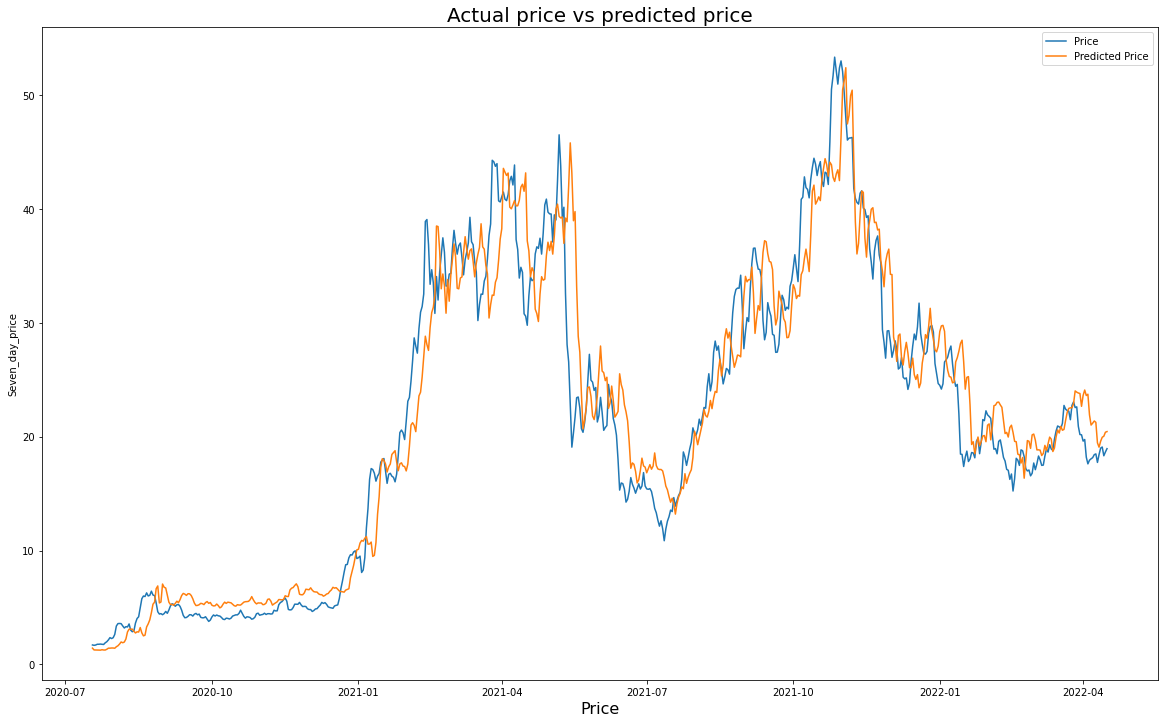

In [29]:
plt.figure(figsize=(20,12))
sns.lineplot(x=df_merged['Date'], y=df_merged['Seven_day_price'], label='Price')
sns.lineplot(x=df_merged['Date'], y=df_merged['prediction'], label='Predicted Price')
plt.title('Actual price vs predicted price', fontsize=20)
plt.xlabel('Price', fontsize=16);

> Although the score of the predictor was good, from visualizing the predictions, we can see that the model has weighted too heavily to the price_USD variable. The prediction resembles the shape of the movements of the target data, but shifted a few days into the future, which makes it questionable as a tool for predicting future price.

## examine difference between predicted result vs real result

In [30]:
train_difference = np.array(train_prediction - y_train)
test_difference = np.array(test_prediction - y_test)
historic_difference = np.array(df_merged['prediction'] - df_merged['Seven_day_price'])

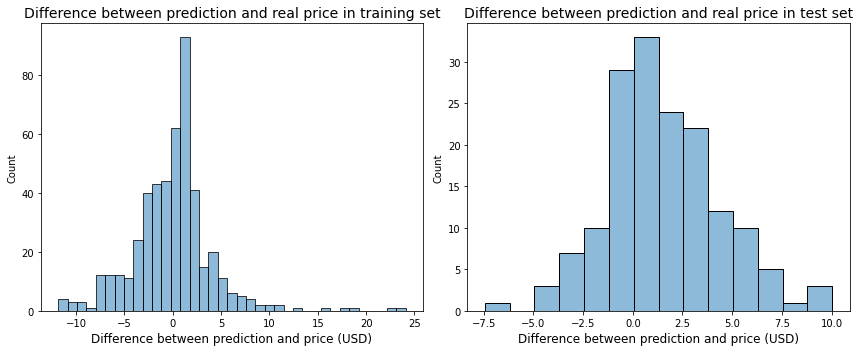

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train_difference, ax=ax1)
ax1.set_title('Difference between prediction and real price in training set', fontsize=14)
ax1.set_xlabel('Difference between prediction and price (USD)', fontsize=12)
sns.histplot(test_difference, ax=ax2)
ax2.set_title('Difference between prediction and real price in test set', fontsize=14)
ax2.set_xlabel('Difference between prediction and price (USD)', fontsize=12)
ax1.get_legend().remove()
ax2.get_legend().remove()
plt.tight_layout();